In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import h5py
import sys

sys.path.append("../Data_Preprocessing/")
from Preprocess_Utilities import *
from Metric import *

In [2]:
# restore trained model & training info into session
sess = tf.InteractiveSession()

saver = tf.train.import_meta_graph('./Result/models/res_serv_road_livi/res_serv_road_livi.meta')
saver.restore(sess, tf.train.latest_checkpoint('./Result/models/res_serv_road_livi/'))

INFO:tensorflow:Restoring parameters from ./Result/models/res_serv_road_livi/res_serv_road_livi


In [3]:
training_info = h5py.File('./Result/models/res_serv_road_livi/training_info.h5')
index = training_info['Index']
norm  = training_info['Norm']

train_index = np.array(index['train_index'])
test_index  = np.array(index['test_index'])
mu    = np.array(norm['mu'])
sigma = np.array(norm['sigma'])
training_info.close()

In [4]:
print(train_index.shape, test_index.shape, mu.shape, sigma.shape)

(260498,) (86833,) (1, 5488) (1, 5488)


In [5]:
# read in & re-construct training/test set
data_path = '../Data/090085/Road_Data/res_serv_road_livi/patch_set.h5'
data = h5py.File(data_path, 'r')
X = np.array(data['image_patch'])
Y = np.array(data['road_existence'])
Road_patch = np.array(data['road_patch'])
data.close()

train_img        = X[train_index]
train_x          = X[train_index].flatten().reshape((train_index.size, -1))
train_y          = Y[train_index]
train_road_patch = Road_patch[train_index]

test_img        = X[test_index]
test_x          = X[test_index].flatten().reshape((test_index.size, -1))
test_y          = Y[test_index]
test_road_patch = Road_patch[test_index]

print(X.shape)
print(train_x.shape, train_y.shape, train_road_patch.shape)
print(test_x.shape, test_y.shape, test_road_patch.shape)
print(train_index.size + test_index.size == X.shape[0])

(347331, 7, 28, 28)
(260498, 5488) (260498,) (260498, 28, 28)
(86833, 5488) (86833,) (86833, 28, 28)
True


In [6]:
# list all names for nodes in TFgraph
graph = tf.get_default_graph()
for op in graph.get_operations():
    print(op.name)

x
y
truncated_normal/shape
truncated_normal/mean
truncated_normal/stddev
truncated_normal/TruncatedNormal
truncated_normal/mul
truncated_normal
Variable
Variable/Assign
Variable/read
truncated_normal_1/shape
truncated_normal_1/mean
truncated_normal_1/stddev
truncated_normal_1/TruncatedNormal
truncated_normal_1/mul
truncated_normal_1
Variable_1
Variable_1/Assign
Variable_1/read
MatMul
add
Relu
truncated_normal_2/shape
truncated_normal_2/mean
truncated_normal_2/stddev
truncated_normal_2/TruncatedNormal
truncated_normal_2/mul
truncated_normal_2
Variable_2
Variable_2/Assign
Variable_2/read
truncated_normal_3/shape
truncated_normal_3/mean
truncated_normal_3/stddev
truncated_normal_3/TruncatedNormal
truncated_normal_3/mul
truncated_normal_3
Variable_3
Variable_3/Assign
Variable_3/read
MatMul_1
add_1
Relu_1
truncated_normal_4/shape
truncated_normal_4/mean
truncated_normal_4/stddev
truncated_normal_4/TruncatedNormal
truncated_normal_4/mul
truncated_normal_4
Variable_4
Variable_4/Assign
Variabl

In [7]:
# get tensor => tensor name = operation name : output index
x = graph.get_tensor_by_name("x:0")
y = graph.get_tensor_by_name("y:0")
prediction = graph.get_tensor_by_name("prediction:0")

In [8]:
# predict training & test set

# training set
train_metric = Metric(record_index=True)
train_pred_label = np.zeros(train_index.size)

batch_size = 64
batch_num = int(train_index.size/batch_size)+1
for i in range(batch_num):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > train_index.size:
        end = train_index.size
    
    batch = [((train_x[start:end]-mu)/sigma), np.matrix(train_y[start:end]).T]
 
    # record metric
    pred = prediction.eval(feed_dict={x:batch[0]})
    train_metric.accumulate(pred, batch[1])
    train_pred_label[start:end] = pred.T

print("Training Result:")
train_metric.print_info()
print()

# test set
test_metric = Metric(record_index=True)
test_pred_label = np.zeros(test_index.size)

batch_size = 64
batch_num = int(test_index.size/batch_size)+1
for i in range(batch_num):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > test_index.size:
        end = test_index.size
    
    batch = [((test_x[start:end]-mu)/sigma), np.matrix(test_y[start:end]).T]

    # record metric   
    pred = prediction.eval(feed_dict={x:batch[0]})
    test_metric.accumulate(pred, batch[1])
    test_pred_label[start:end] = pred.T

print("Test Result:")
test_metric.print_info()

Training Result:
true_pos  = 2147
false_pos = 9434
true_neg  = 248545
false_neg = 372
size = 260498
pos_recall    = 0.852322350139
pos_precision = 0.185389862706
pos_F1        = 0.304539007092
neg_precision = 0.998505525938
neg_recall    = 0.963431131991
neg_F1        = 0.980654808876
accuracy      = 0.96235671675

Test Result:
true_pos  = 669
false_pos = 3200
true_neg  = 82839
false_neg = 125
size = 86833
pos_recall    = 0.842569269521
pos_precision = 0.17291289739
pos_F1        = 0.286939738366
neg_precision = 0.998493322405
neg_recall    = 0.962807564012
neg_F1        = 0.980325793033
accuracy      = 0.961708106365


In [9]:
print(X.shape, train_x.shape, test_x.shape)

(347331, 7, 28, 28) (260498, 5488) (86833, 5488)


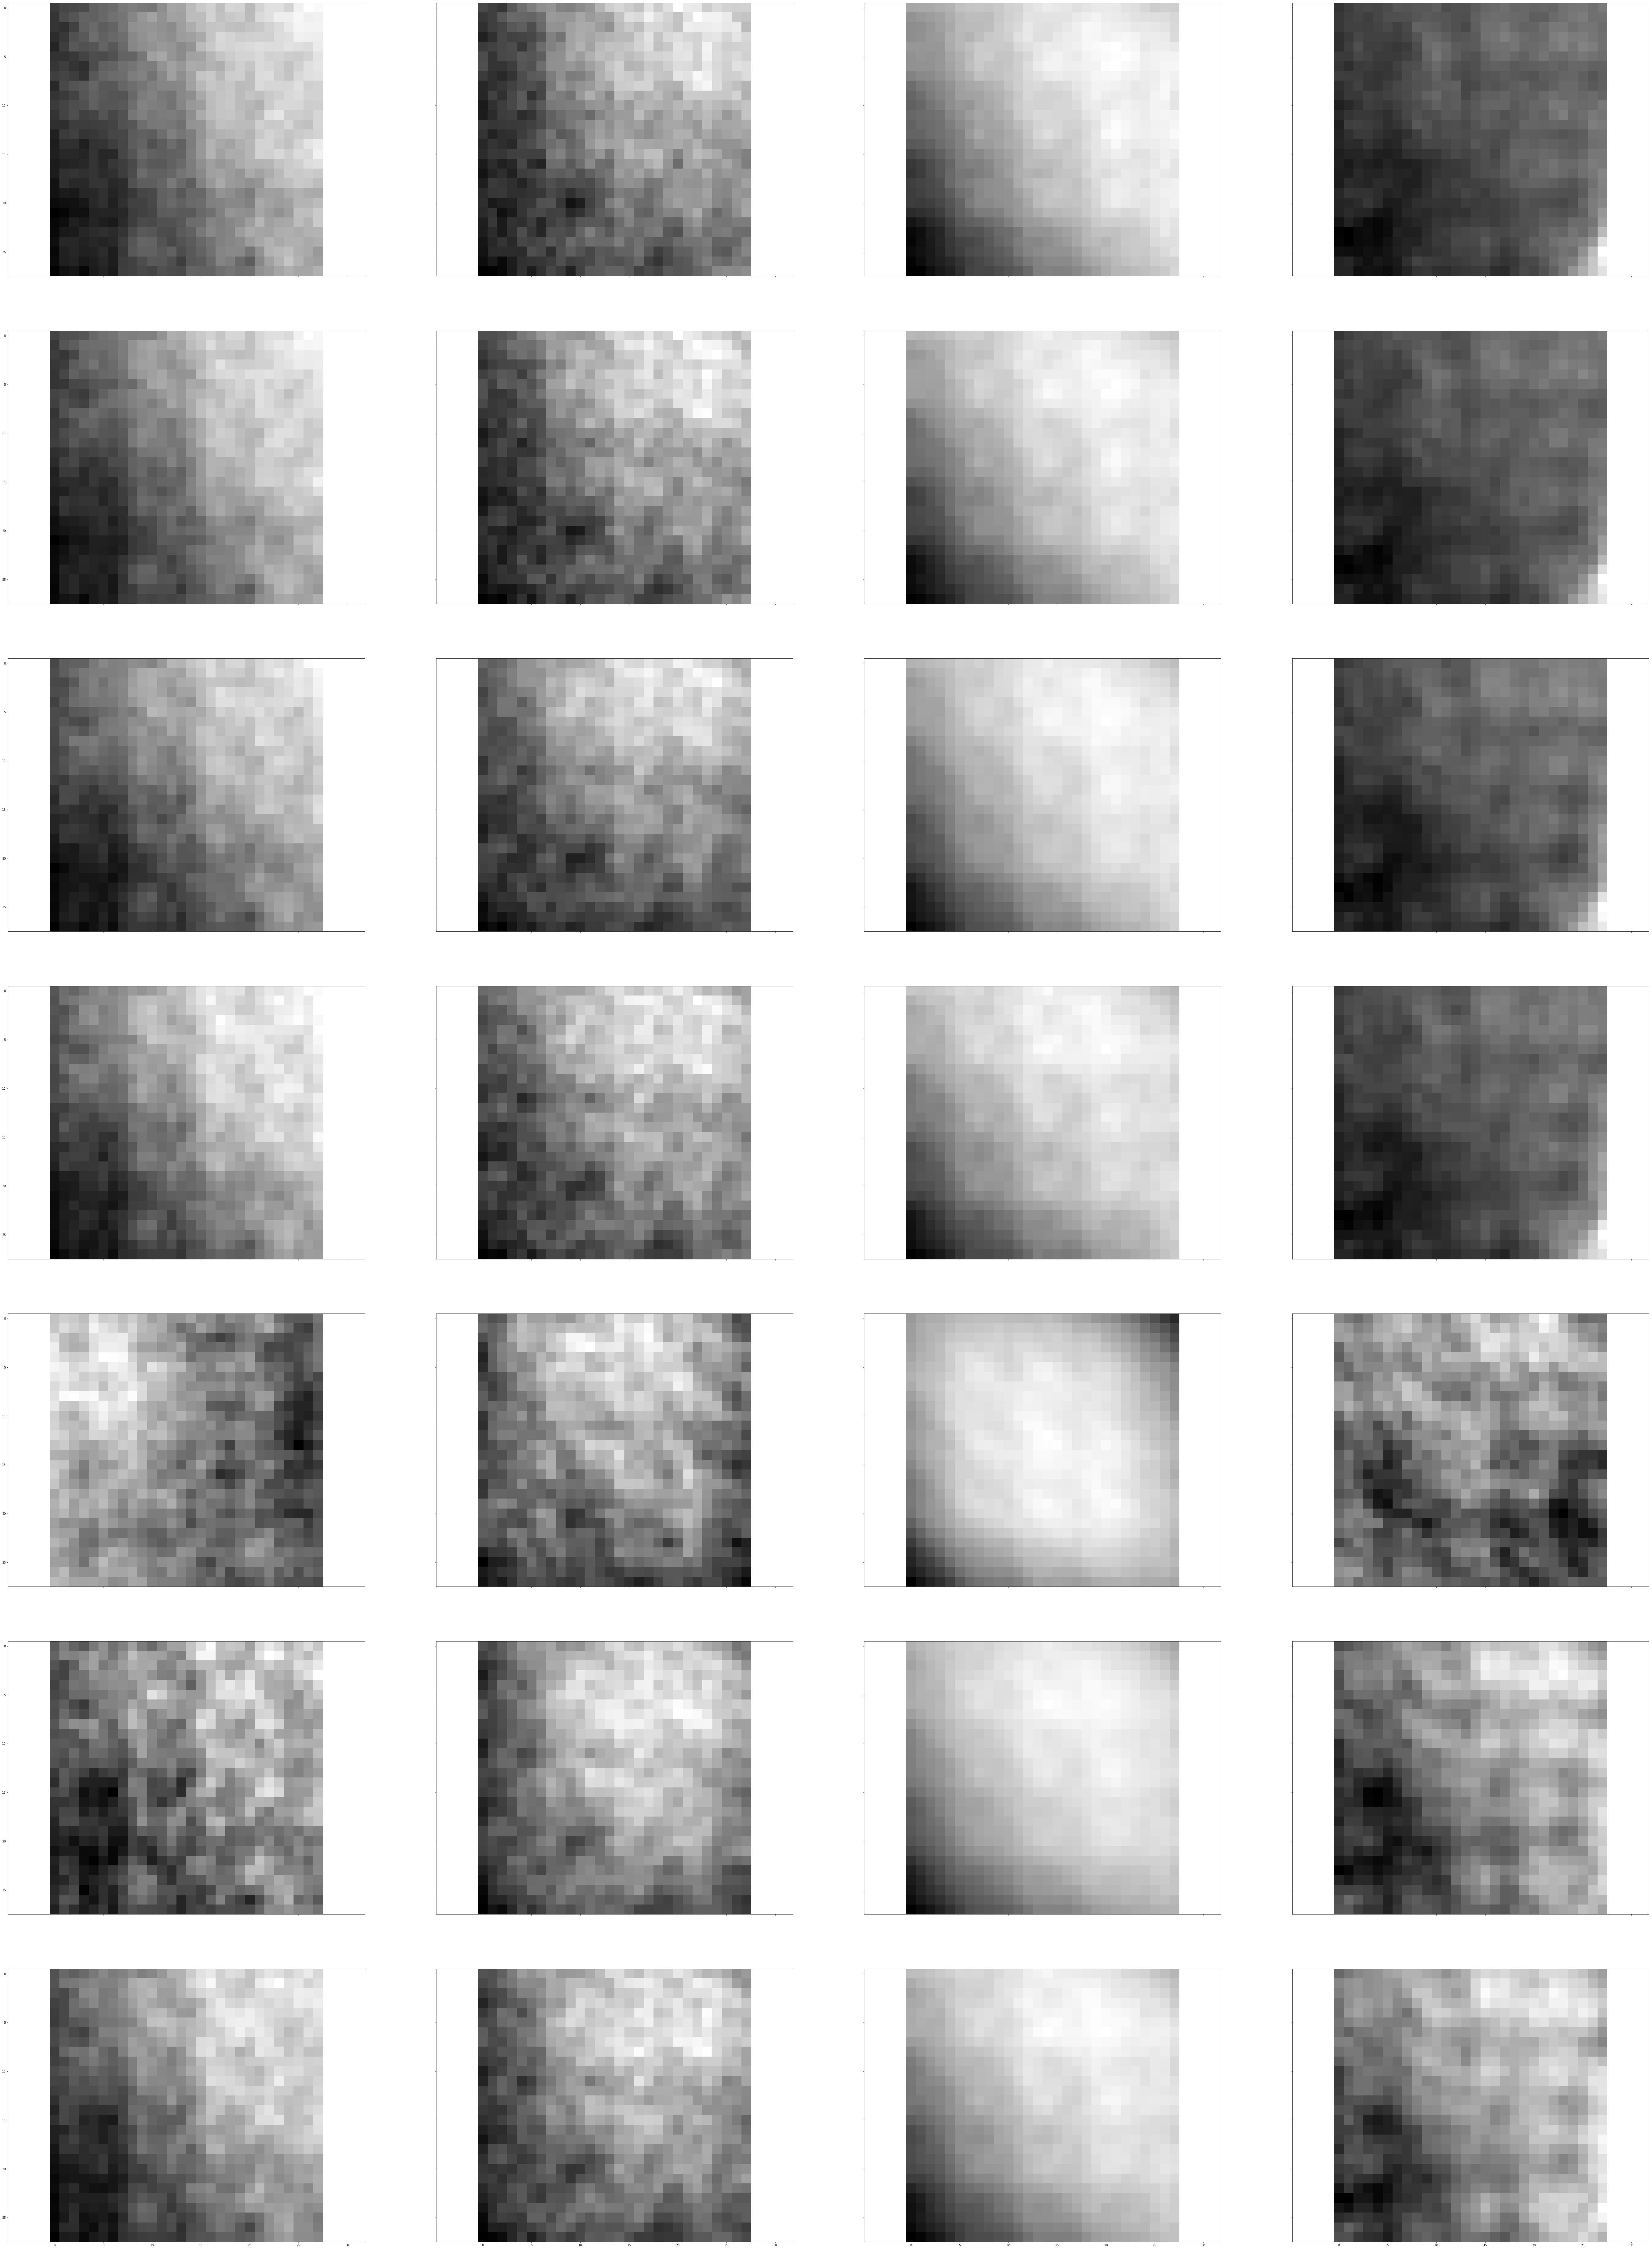

In [15]:
# band img - average over TP/FP/TN/FN (train set)
band_num = 7
plt.close('all')

fig, subfig = plt.subplots(nrows=band_num, ncols=4, sharex=True, sharey=True, figsize=(100,20*band_num))
for band_idx in range(band_num):
    
    band_img = train_img[:,band_idx,:,:]    
    for i, idx_label in zip(range(4), ['TP', 'FP', 'TN', 'FN']):
        img_idx = train_metric.get_index(idx_label)        
        subfig[band_idx,i].imshow(train_x[img_idx].mean(axis=0).reshape((7,28,28))[band_idx], 
                                   cmap=plt.get_cmap('gray'))

plt.savefig('./Result/models/res_serv_road_livi/Analysis/Band - avg on TP_FP_TN_FN.png')
plt.show()

(347331, 28, 28) (784,) (347331, 784)


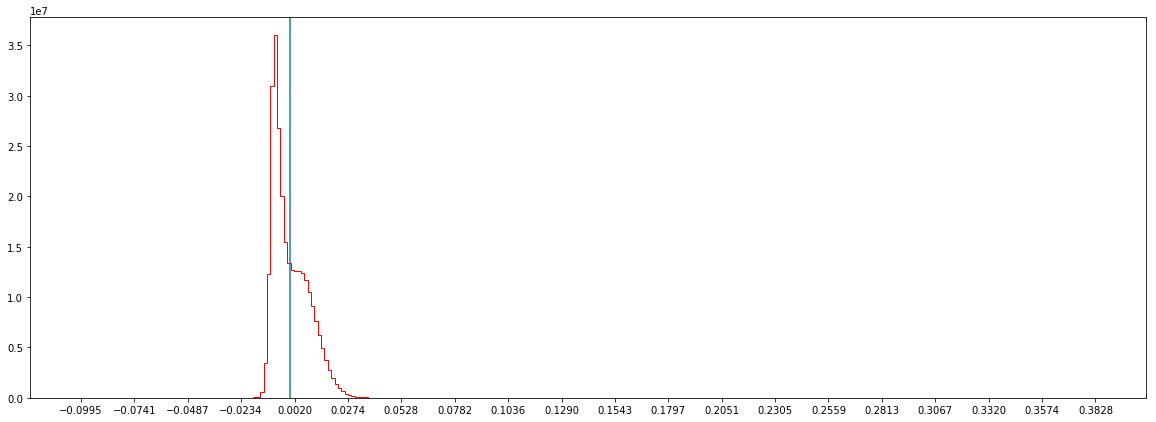

(347331, 28, 28) (784,) (347331, 784)


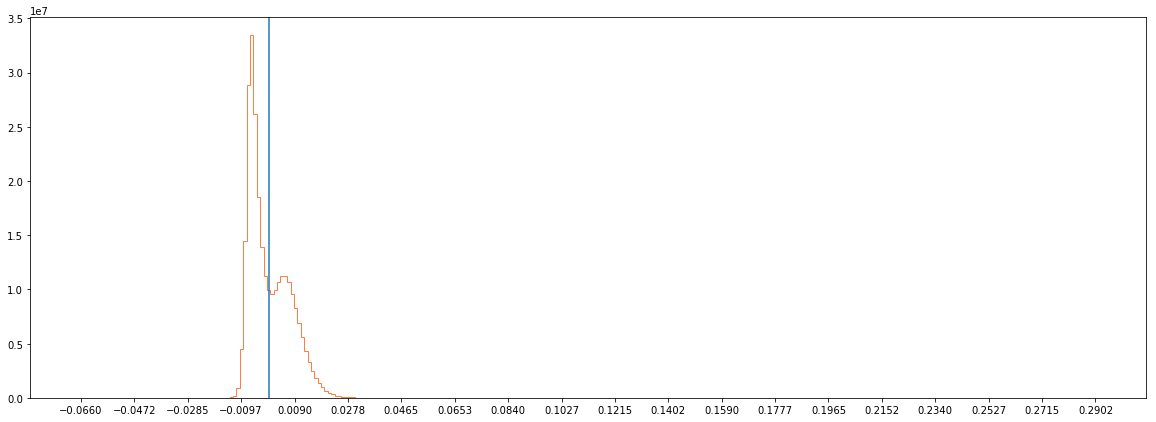

(347331, 28, 28) (784,) (347331, 784)


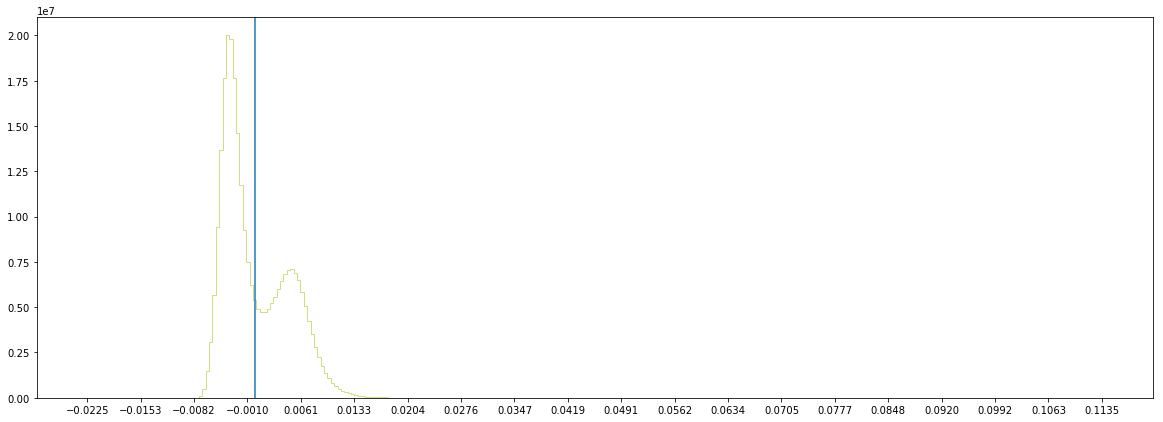

(347331, 28, 28) (784,) (347331, 784)


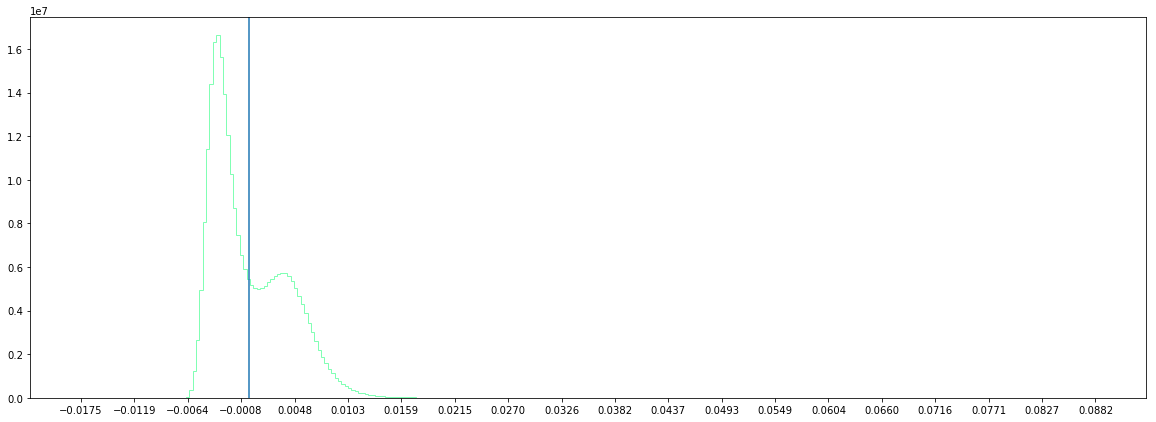

(347331, 28, 28) (784,) (347331, 784)


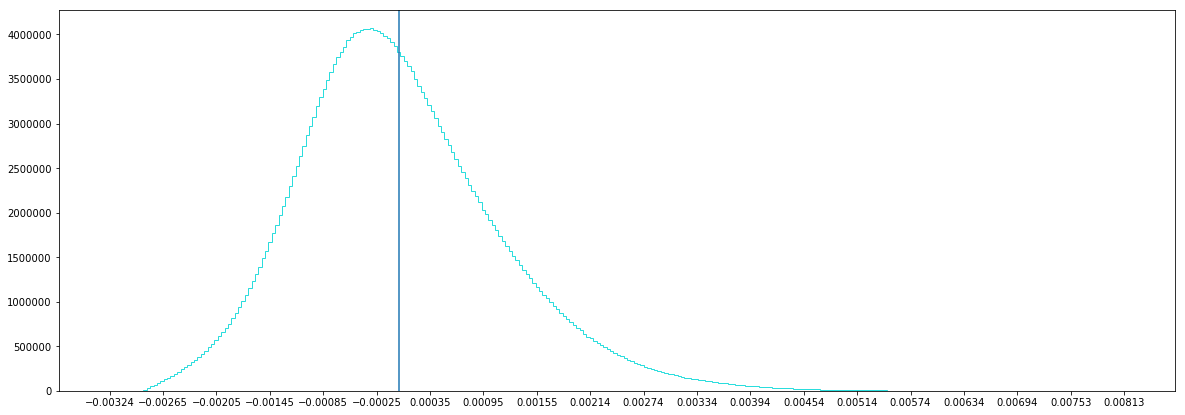

(347331, 28, 28) (784,) (347331, 784)


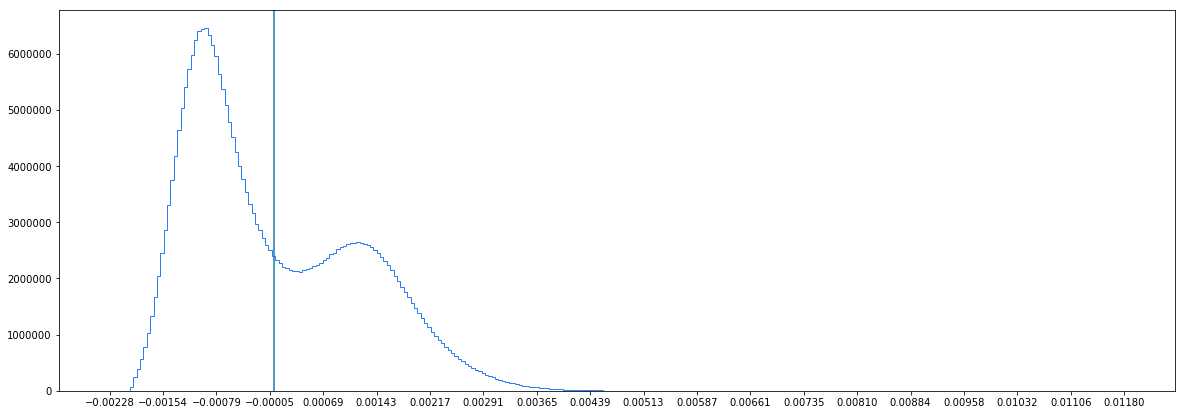

(347331, 28, 28) (784,) (347331, 784)


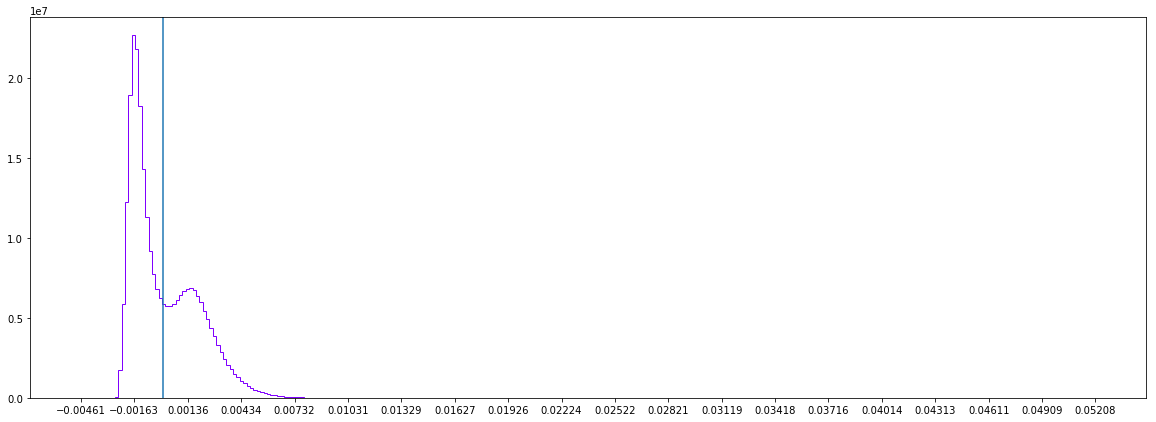

In [24]:
# band info - whole dataset
band_num = 7
for band_idx, band_color in zip(range(band_num), reversed(cm.rainbow(np.linspace(0, 1, band_num)))):
    band       = X[:,band_idx,:,:]
    band_mu    = (mu.reshape((7,28,28)))[band_idx, :, :].flatten()
    band_sigma = (sigma.reshape((7,28,28)))[band_idx, :, :].flatten()

    band_norm = (band.reshape((band.shape[0], -1))-band_mu)/band_sigma
    print(band.shape, band_mu.shape, band_norm.shape)
    
    plt.figure(figsize=(20,7))
    plt.xticks(np.linspace(band_norm.min(),band_norm.max(), 20))
    plt.hist(band_norm.flatten(), bins=300, color=band_color, histtype='step')
    plt.axvline(0)
    plt.show()

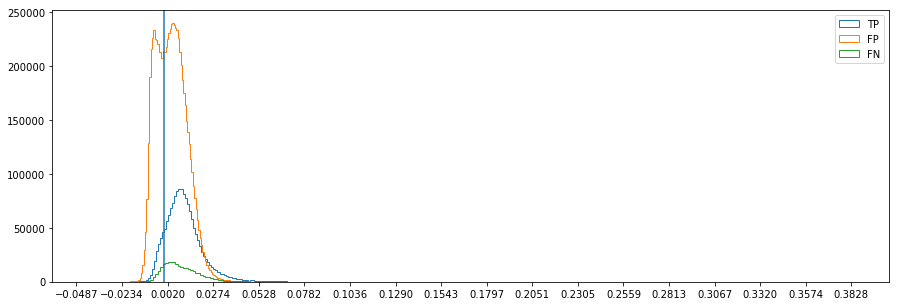

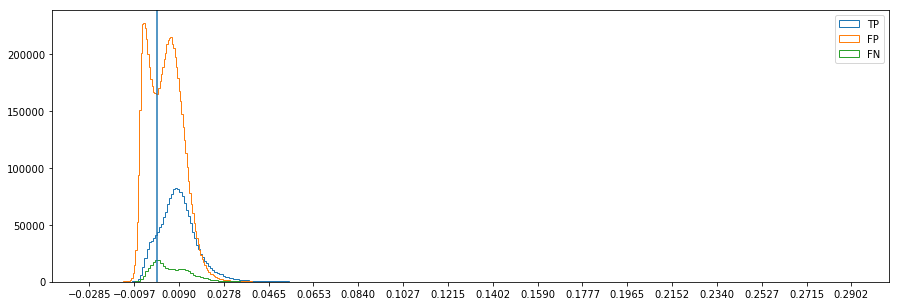

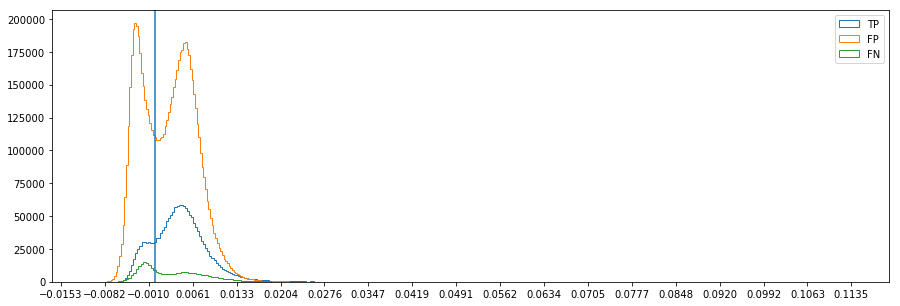

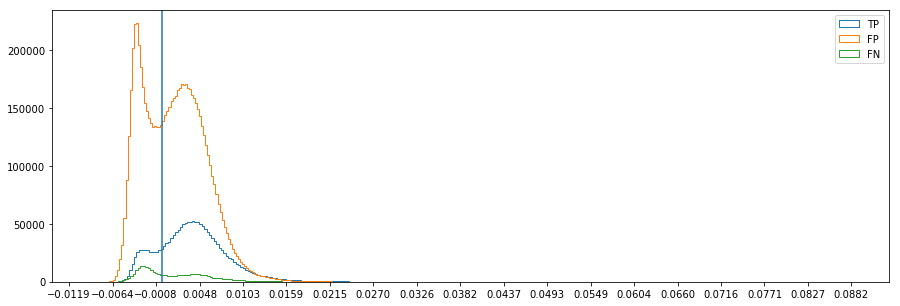

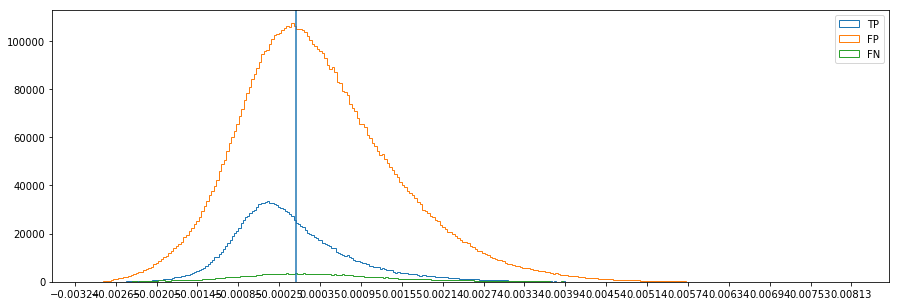

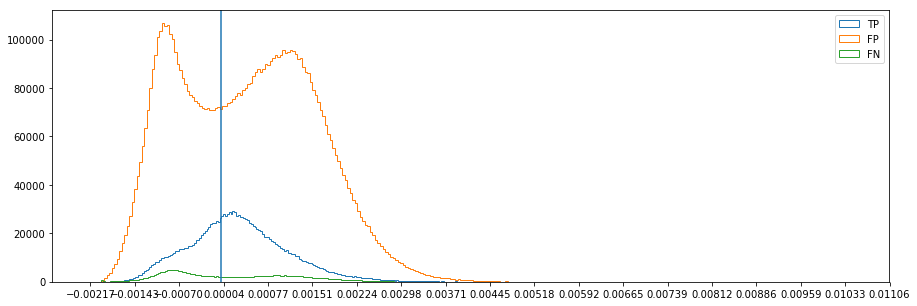

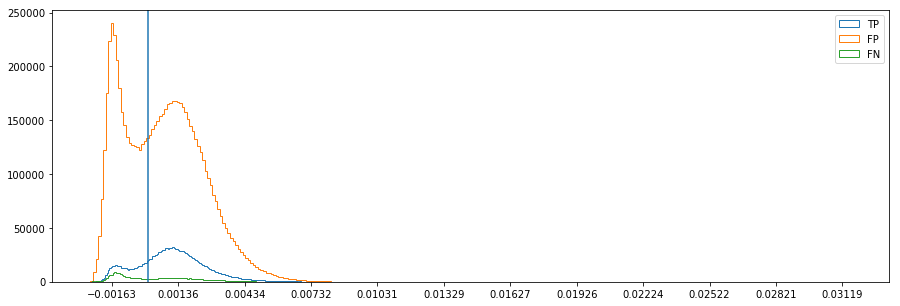

In [26]:
# band info - TP/FP/TN/FN on training set
band_num = 7
for band_idx in range(band_num):
    band       = train_img[:,band_idx,:,:]
    band_mu    = (mu.reshape((7,28,28)))[band_idx, :, :].flatten()
    band_sigma = (sigma.reshape((7,28,28)))[band_idx, :, :].flatten()

    band_norm = (band.reshape((band.shape[0], -1))-band_mu)/band_sigma # normalized band img (flatten)
    
    plt.figure(figsize=(15,5))
    plt.xticks(np.linspace(band_norm.min(),band_norm.max(), 20))
    plt.axvline(0)
    
    for idx_name in ['TP', 'FP', 'FN']:
        
        plt.hist(band_norm[train_metric.get_index(idx_name)].flatten(), 
                 bins=300, histtype='step', label=idx_name)
    plt.legend()
    plt.savefig("./Result/Band Info/band " + str(band_idx))
    plt.show()

    print("===================================================================================")

In [ ]:
# false pos
for i in range(10):
    idx = np.random.randint(0, len(false_pos_idx))
    idx = false_pos_idx[idx]
    print(idx)
    
    img  = X[idx].reshape(7, 28, 28)
    road = Road_patch[idx]
    show_image_against_road(img, road, size = -1, figsize=None, show_raw=False)
    for band in range(7):
        plt.imshow(img[band, :, :], cmap=plt.get_cmap('gray'))
        plt.show()
    break

In [ ]:
# true pos
for i in range(10):
    idx = np.random.randint(0, len(true_pos_idx))
    idx = true_pos_idx[idx]
    print(idx)
    
    img  = X[idx].reshape(7, 28, 28)
    road = Road_patch[idx]
    show_image_against_road(img, road, size = -1, figsize=None,show_raw=True)
    for band in range(7):
        plt.imshow(img[band, :, :], cmap=plt.get_cmap('gray'))
        plt.show()
    break